In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import itertools

from scipy.stats import mode

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import roc_auc_score
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC, SVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

#conda install -c conda-forge imbalanced-learn
from imblearn.over_sampling import RandomOverSampler
from imblearn.pipeline import make_pipeline as make_imb_pipeline

In [2]:
PLOT_SIZE = 16
SAMPLE_SIZE = 2000
SEED = 2022
RADIUS = 0.3
ACCURACY = 0.95

In [3]:
def true_function(x1,x2,r=RADIUS):
    if((x1-1.5)**2 + (x2-1)**2 < r or (x1-0.5)**2 + (x2-0.5)**2 < 2 * r or (x1+1)**2 + (x2+1)**2 < 0.5 * r):
        return(1)
    else:
        return(0)

In [4]:
x1_min = -2.5
x1_max = 2.5
x2_min = -2.5
x2_max = 2.5

In [5]:
x1 = np.arange(x1_min, x1_max, 0.01)
x2 = np.arange(x2_min, x2_max, 0.01)
coordinates = np.array([x for x in itertools.product(x1,x2)])
f_x = [true_function(x1,x2) for x1,x2 in coordinates]
x1 = [x1 for x1,x2 in coordinates]
x2 = [x2 for x1,x2 in coordinates]

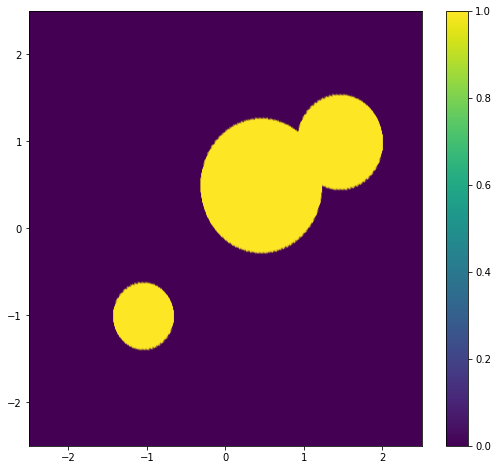

In [6]:
fig, ax = plt.subplots(1, 1, figsize=(1.1 * PLOT_SIZE/2, PLOT_SIZE/2))

plt.scatter(x1, x2, c=f_x, vmin=0, vmax=1)
plt.colorbar()

plt.xlim(x1_min, x1_max)
plt.ylim(x2_min, x2_max)

plt.show()

In [7]:
def add_noise(x):
    x = np.array(x)
    return(np.where(
        np.random.uniform(size=len(x)) <= ACCURACY,
        x,
        1-x
    ))

In [8]:
np.random.seed(seed=SEED)
idx = np.random.choice(len(coordinates),SAMPLE_SIZE)
coordinates_ = np.array(coordinates)[idx]
x1_ = [x1 for x1,x2 in coordinates_]
x2_ = [x2 for x1,x2 in coordinates_]
f_x_ = [true_function(x1,x2) for x1,x2 in coordinates]

y_ = add_noise([true_function(x1,x2) for x1,x2 in coordinates_])

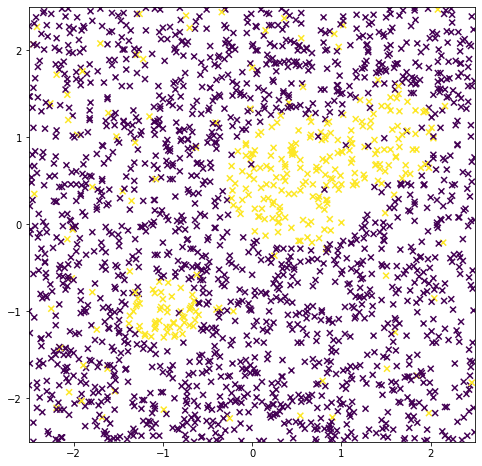

In [9]:
fig, ax = plt.subplots(1, 1, figsize=(PLOT_SIZE/2, PLOT_SIZE/2))

ax.scatter(x1_,x2_,c=y_,marker = 'x')

plt.xlim(x1_min, x1_max)
plt.ylim(x2_min, x2_max)

plt.show()

# Split train and test

In [10]:
X_train, X_test, y_train, y_test = train_test_split(
    coordinates_,
    y_,
    stratify = y_, 
    random_state=SEED+1)

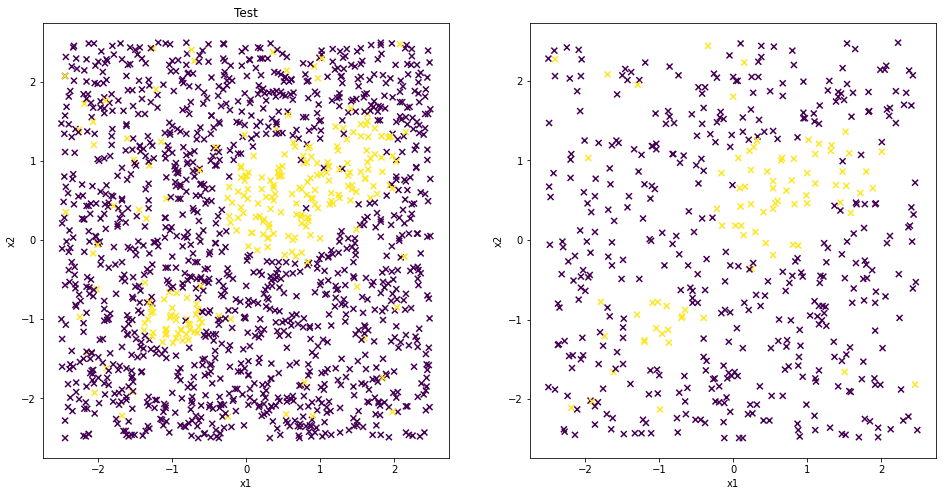

In [11]:
fig, ax = plt.subplots(1, 2, figsize=(PLOT_SIZE, PLOT_SIZE/2))

#ax.plot(x, f_x)
ax[0].scatter(X_train[:,0], X_train[:,1], c=y_train, marker='x')
ax[0].set_xlabel('x1')
ax[0].set_ylabel('x2')
ax[0].set_title('Train')

ax[1].scatter(X_test[:,0], X_test[:,1], c=y_test, marker='x')
ax[1].set_xlabel('x1')
ax[1].set_ylabel('x2')
ax[0].set_title('Test')

plt.show()

# Modeling

## Baseline

In [12]:
proportion = np.mean(y_train)

def fx_baseline(x1,x2):
    return(proportion)

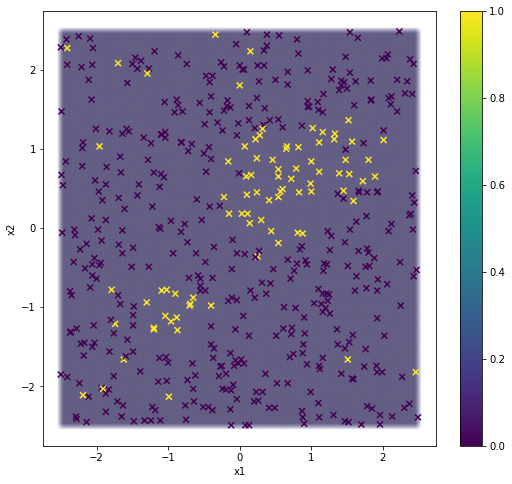

In [13]:
fig, ax = plt.subplots(1, 1, figsize=(1.1* PLOT_SIZE/2, PLOT_SIZE/2))

fx_plot = [fx_baseline(x1,x2) for x1, x2 in coordinates]
plt.scatter(x1, x2, c=fx_plot, vmin=0, vmax=1, alpha=0.01)
plt.scatter(X_test[:,0], X_test[:,1], c=y_test, marker='x')
plt.colorbar()

ax.set_xlabel('x1')
ax.set_ylabel('x2')

plt.show()

In [14]:
fx_test_baseline = [fx_baseline(x1,x2) for x1,x2 in X_test]
auc_baseline = roc_auc_score(y_test, fx_test_baseline)
print('AUC (Baseline): ' + str(round(auc_baseline, 2)))

AUC (Baseline): 0.5


## Logistic Model

### Naive Approach

In [15]:
logistic_model = make_pipeline(StandardScaler(), LogisticRegression())

In [16]:
logistic_model.fit(X_train, y_train)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('logisticregression', LogisticRegression())])

In [17]:
def fx_lm(x):
    return(logistic_model.predict_proba(x))

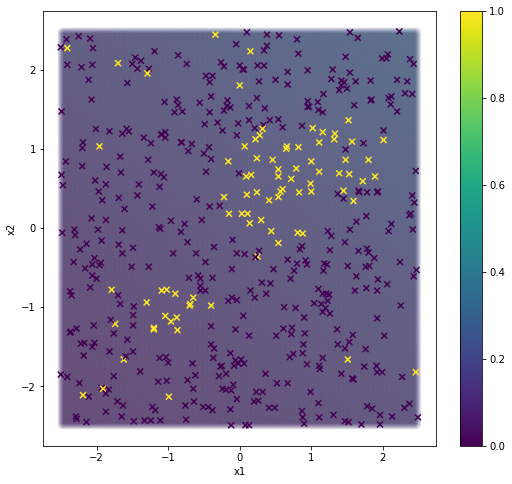

In [18]:
fig, ax = plt.subplots(1, 1, figsize=(1.1* PLOT_SIZE/2, PLOT_SIZE/2))

fx_plot = fx_lm(coordinates)[:,1]
plt.scatter(x1, x2, c=fx_plot, vmin=0, vmax=1, alpha = 0.01)
plt.scatter(X_test[:,0], X_test[:,1], c=y_test, marker='x')
plt.colorbar()

ax.set_xlabel('x1')
ax.set_ylabel('x2')

plt.show()

In [19]:
fx_test_logistic_naive = fx_lm(X_test)[:,1]
auc_logistic_naive = roc_auc_score(y_test, fx_test_logistic_naive)
print('AUC (Baseline): ' + str(round(auc_baseline, 2)))
print('AUC (Logistic - Naive): ' + str(round(auc_logistic_naive, 2)))

AUC (Baseline): 0.5
AUC (Logistic - Naive): 0.6


### Optimize Polynomial 

In [20]:
logistic_polynomial_model = make_imb_pipeline(
    StandardScaler(),
    #RandomOverSampler(), 
    PolynomialFeatures(degree=20, interaction_only=False),
    LogisticRegression(max_iter = 1e4))
param_grid_logistic_polynomial = [{'polynomialfeatures__degree': np.arange(4,10,2),
                        'logisticregression__C': np.logspace(-2, 2, 5)}]
grid_logistic_polynomial = GridSearchCV(logistic_polynomial_model, param_grid_logistic_polynomial, cv=5, scoring='roc_auc', refit='roc_auc')
np.random.seed(SEED)
grid_logistic_polynomial.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('standardscaler', StandardScaler()),
                                       ('polynomialfeatures',
                                        PolynomialFeatures(degree=20)),
                                       ('logisticregression',
                                        LogisticRegression(max_iter=10000.0))]),
             param_grid=[{'logisticregression__C': array([1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02]),
                          'polynomialfeatures__degree': array([4, 6, 8])}],
             refit='roc_auc', scoring='roc_auc')

In [21]:
grid_logistic_polynomial.best_params_

{'logisticregression__C': 100.0, 'polynomialfeatures__degree': 6}

In [22]:
def fx_lm(x):
    return(grid_logistic_polynomial.predict_proba(x))

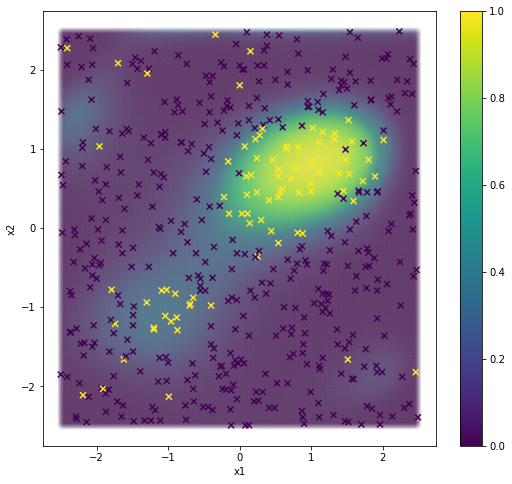

In [23]:
fig, ax = plt.subplots(1, 1, figsize=(1.1* PLOT_SIZE/2, PLOT_SIZE/2))

fx_plot = fx_lm(coordinates)[:,1]
plt.scatter(x1, x2, c=fx_plot, vmin=0, vmax=1, alpha = 0.01)
plt.scatter(X_test[:,0], X_test[:,1], c=y_test, marker='x')
plt.colorbar()

ax.set_xlabel('x1')
ax.set_ylabel('x2')

plt.show()

In [24]:
fx_test_logistic_polynomial = fx_lm(X_test)[:,1]
auc_logistic_polynomial = roc_auc_score(y_test, fx_test_logistic_polynomial)
print('AUC (Baseline): ' + str(round(auc_baseline, 2)))
print('AUC (Logistic - Naive): ' + str(round(auc_logistic_naive, 2)))
print('AUC (Logistic - Polynomial): ' + str(round(auc_logistic_polynomial, 2)))

AUC (Baseline): 0.5
AUC (Logistic - Naive): 0.6
AUC (Logistic - Polynomial): 0.88


### Balance Data

In [25]:
logistic_model = make_imb_pipeline(
    StandardScaler(),
    RandomOverSampler(), 
    PolynomialFeatures(degree=20, interaction_only=False),
    LogisticRegression(max_iter = 1e5))
param_grid_logistic = [{'polynomialfeatures__degree': np.arange(4,10,2),
                        'logisticregression__C': np.logspace(-2, 2, 5)}]
grid_logistic = GridSearchCV(logistic_model, param_grid_logistic, cv=5, scoring='roc_auc', refit='roc_auc')
np.random.seed(SEED)
grid_logistic.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('standardscaler', StandardScaler()),
                                       ('randomoversampler',
                                        RandomOverSampler()),
                                       ('polynomialfeatures',
                                        PolynomialFeatures(degree=20)),
                                       ('logisticregression',
                                        LogisticRegression(max_iter=100000.0))]),
             param_grid=[{'logisticregression__C': array([1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02]),
                          'polynomialfeatures__degree': array([4, 6, 8])}],
             refit='roc_auc', scoring='roc_auc')

In [26]:
def fx_lm(x):
    return(grid_logistic.predict_proba(x))

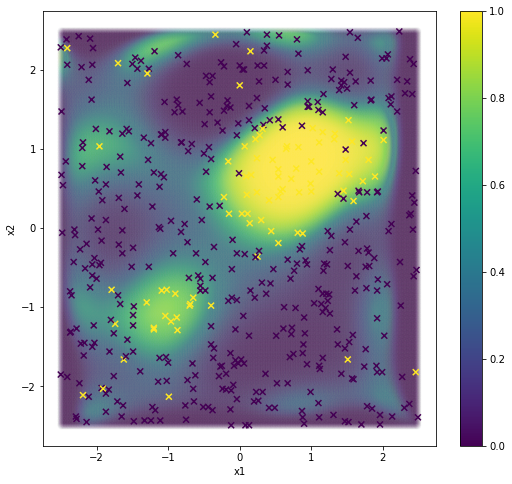

In [27]:
fig, ax = plt.subplots(1, 1, figsize=(1.1* PLOT_SIZE/2, PLOT_SIZE/2))

fx_plot = fx_lm(coordinates)[:,1]
plt.scatter(x1, x2, c=fx_plot, vmin=0, vmax=1, alpha = 0.01)
plt.scatter(X_test[:,0], X_test[:,1], c=y_test, marker='x')
plt.colorbar()

ax.set_xlabel('x1')
ax.set_ylabel('x2')

plt.show()

In [28]:
fx_test_logistic = fx_lm(X_test)[:,1]
auc_logistic = roc_auc_score(y_test, fx_test_logistic)
print('AUC (Baseline): ' + str(round(auc_baseline, 2)))
print('AUC (Logistic - Naive): ' + str(round(auc_logistic_naive, 2)))
print('AUC (Logistic - Polynomial): ' + str(round(auc_logistic_polynomial, 2)))
print('AUC (Logistic - Balanced): ' + str(round(auc_logistic, 2)))

AUC (Baseline): 0.5
AUC (Logistic - Naive): 0.6
AUC (Logistic - Polynomial): 0.88
AUC (Logistic - Balanced): 0.9


## SVM

### Linear SVM

In [30]:
linearsvm_model = make_imb_pipeline(StandardScaler(), RandomOverSampler(), LinearSVC(max_iter = 1e4))
param_grid_linearsvm = {'linearsvc__C': np.logspace(-3, 3, 13)}
grid_linearsvm = GridSearchCV(linearsvm_model, param_grid_linearsvm, cv=5, scoring='roc_auc', refit='roc_auc')
np.random.seed(SEED)
grid_linearsvm.fit(X_train, y_train)

/Users/opardo/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/opardo/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/opardo/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/opardo/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/opardo/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the num

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('standardscaler', StandardScaler()),
                                       ('randomoversampler',
                                        RandomOverSampler()),
                                       ('linearsvc',
                                        LinearSVC(max_iter=10000.0))]),
             param_grid={'linearsvc__C': array([1.00000000e-03, 3.16227766e-03, 1.00000000e-02, 3.16227766e-02,
       1.00000000e-01, 3.16227766e-01, 1.00000000e+00, 3.16227766e+00,
       1.00000000e+01, 3.16227766e+01, 1.00000000e+02, 3.16227766e+02,
       1.00000000e+03])},
             refit='roc_auc', scoring='roc_auc')

In [31]:
grid_linearsvm.best_params_

{'linearsvc__C': 1.0}

In [32]:
def fx_linearsvc(x):
    return(grid_linearsvm.predict(x))

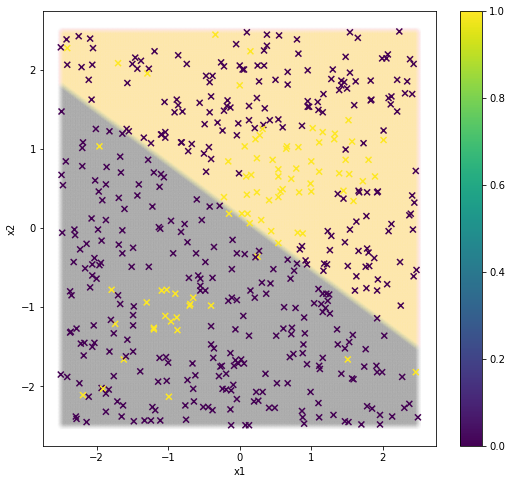

In [33]:
fig, ax = plt.subplots(1, 1, figsize=(1.1* PLOT_SIZE/2, PLOT_SIZE/2))

fx_plot = fx_linearsvc(coordinates)
plt.scatter(x1, x2, c=fx_plot, vmin=0, vmax=1, alpha = 0.005)
plt.scatter(X_test[:,0], X_test[:,1], c=y_test, marker='x')
plt.colorbar()

ax.set_xlabel('x1')
ax.set_ylabel('x2')

plt.show()

In [34]:
fx_test_linearsvc = fx_linearsvc(X_test)
auc_linearsvc = roc_auc_score(y_test, fx_test_linearsvc)
print('AUC (Baseline): ' + str(round(auc_baseline, 2)))
print('AUC (Logistic): ' + str(round(auc_logistic, 2)))
print('AUC (Linear SVC): ' + str(round(auc_linearsvc, 2)))

AUC (Baseline): 0.5
AUC (Logistic): 0.9
AUC (Linear SVC): 0.64


### Other Kernels 

In [35]:
svm_model = make_imb_pipeline(StandardScaler(), RandomOverSampler(), SVC(probability = True, max_iter = 1e4))
param_grid_svm = [{'svc__C': np.logspace(-2, 2, 5),
                   'svc__kernel': ['poly', 'rbf', 'sigmoid']}]
grid_svm = GridSearchCV(svm_model, param_grid_svm, cv=5, scoring='roc_auc', refit='roc_auc')
np.random.seed(SEED)
grid_svm.fit(X_train, y_train)

/Users/opardo/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:249: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/opardo/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:249: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/opardo/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:249: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/opardo/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:249: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarni

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('standardscaler', StandardScaler()),
                                       ('randomoversampler',
                                        RandomOverSampler()),
                                       ('svc',
                                        SVC(max_iter=10000.0,
                                            probability=True))]),
             param_grid=[{'svc__C': array([1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02]),
                          'svc__kernel': ['poly', 'rbf', 'sigmoid']}],
             refit='roc_auc', scoring='roc_auc')

In [36]:
grid_svm.best_params_

{'svc__C': 100.0, 'svc__kernel': 'rbf'}

In [37]:
def fx_svc(x):
    return(grid_svm.predict_proba(x))

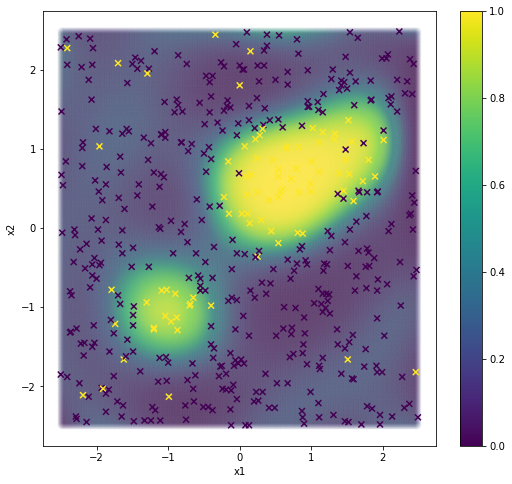

In [38]:
fig, ax = plt.subplots(1, 1, figsize=(1.1* PLOT_SIZE/2, PLOT_SIZE/2))

fx_plot = fx_svc(coordinates)[:,1]
plt.scatter(x1, x2, c=fx_plot, vmin=0, vmax=1, alpha = 0.01)
plt.scatter(X_test[:,0], X_test[:,1], c=y_test, marker='x')
plt.colorbar()

ax.set_xlabel('x1')
ax.set_ylabel('x2')

plt.show()

In [39]:
fx_test_svc = fx_svc(X_test)[:,1]
auc_svc = roc_auc_score(y_test, fx_test_svc)
print('AUC (Baseline): ' + str(round(auc_baseline, 2)))
print('AUC (Logistic): ' + str(round(auc_logistic, 2)))
print('AUC (Linear SVM): ' + str(round(auc_linearsvc, 2)))
print('AUC (SVM): ' + str(round(auc_svc, 2)))

AUC (Baseline): 0.5
AUC (Logistic): 0.9
AUC (Linear SVM): 0.64
AUC (SVM): 0.91


## Random Forest

In [40]:
rf_model = make_imb_pipeline(
    RandomOverSampler(),
    PolynomialFeatures(degree=20, interaction_only=False),
    StandardScaler(),
    RandomForestClassifier(warm_start=True, random_state=0)
)
param_grid_rf = [{'randomforestclassifier__max_leaf_nodes':range(20, 60, 10),
                  'polynomialfeatures__degree': np.arange(0,8,2)}]
grid_rf = GridSearchCV(rf_model, param_grid_rf, cv=5, scoring='roc_auc', refit='roc_auc')
np.random.seed(SEED)
grid_rf.fit(X_train, y_train)

/Users/opardo/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/opardo/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/opardo/anaconda3/lib/python3.7/site-packages/imblearn/pipeline.py", line 277, in fit
    Xt, yt, fit_params = self._fit(X, y, **fit_params)
  File "/Users/opardo/anaconda3/lib/python3.7/site-packages/imblearn/pipeline.py", line 233, in _fit
    **fit_params_steps[name]
  File "/Users/opardo/anaconda3/lib/python3.7/site-packages/joblib/memory.py", line 352, in __call__
    return self.func(*args, **kwargs)
  File "/Users/opardo/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py", line 740, in _fit_transform_one
    res = transformer.

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('randomoversampler',
                                        RandomOverSampler()),
                                       ('polynomialfeatures',
                                        PolynomialFeatures(degree=20)),
                                       ('standardscaler', StandardScaler()),
                                       ('randomforestclassifier',
                                        RandomForestClassifier(random_state=0,
                                                               warm_start=True))]),
             param_grid=[{'polynomialfeatures__degree': array([0, 2, 4, 6]),
                          'randomforestclassifier__max_leaf_nodes': range(20, 60, 10)}],
             refit='roc_auc', scoring='roc_auc')

In [41]:
grid_rf.best_params_

{'polynomialfeatures__degree': 4, 'randomforestclassifier__max_leaf_nodes': 20}

In [42]:
def fx_rf(x):
    return(grid_rf.predict_proba(x))

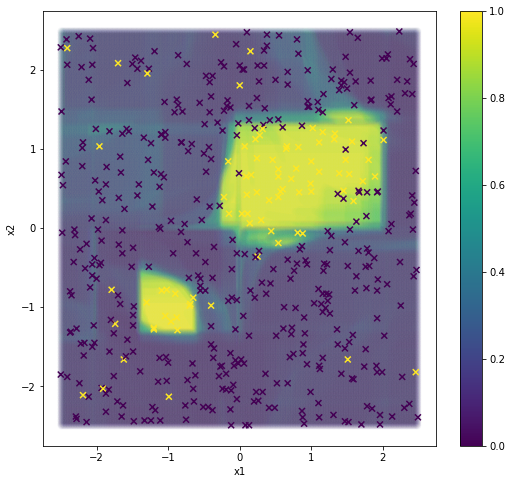

In [43]:
fig, ax = plt.subplots(1, 1, figsize=(1.1* PLOT_SIZE/2, PLOT_SIZE/2))

fx_plot = fx_rf(coordinates)[:,1]
plt.scatter(x1, x2, c=fx_plot, vmin=0, vmax=1, alpha = 0.01)
plt.scatter(X_test[:,0], X_test[:,1], c=y_test, marker='x')
plt.colorbar()

ax.set_xlabel('x1')
ax.set_ylabel('x2')

plt.show()

In [44]:
fx_test_rf = fx_rf(X_test)[:,1]
auc_rf = roc_auc_score(y_test, fx_test_rf)
print('AUC (Baseline): ' + str(round(auc_baseline, 2)))
print('AUC (Logistic): ' + str(round(auc_logistic, 2)))
print('AUC (SVM): ' + str(round(auc_svc, 2)))
print('AUC (Random Forests): ' + str(round(auc_rf, 2)))

AUC (Baseline): 0.5
AUC (Logistic): 0.9
AUC (SVM): 0.91
AUC (Random Forests): 0.88


## Gradient Boosting

In [45]:
gb_model = make_imb_pipeline(
    RandomOverSampler(),
    PolynomialFeatures(degree=20, interaction_only=False),
    StandardScaler(),
    GradientBoostingClassifier()
)
param_grid_gb = [{'gradientboostingclassifier__learning_rate': np.logspace(-2, 0, 5),
                  'polynomialfeatures__degree': np.arange(2,8,2)}]
grid_gb = GridSearchCV(gb_model, param_grid_gb, cv=5, scoring='roc_auc', refit='roc_auc')
np.random.seed(SEED)
grid_gb.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('randomoversampler',
                                        RandomOverSampler()),
                                       ('polynomialfeatures',
                                        PolynomialFeatures(degree=20)),
                                       ('standardscaler', StandardScaler()),
                                       ('gradientboostingclassifier',
                                        GradientBoostingClassifier())]),
             param_grid=[{'gradientboostingclassifier__learning_rate': array([0.01      , 0.03162278, 0.1       , 0.31622777, 1.        ]),
                          'polynomialfeatures__degree': array([2, 4, 6])}],
             refit='roc_auc', scoring='roc_auc')

In [46]:
grid_gb.best_params_

{'gradientboostingclassifier__learning_rate': 0.1,
 'polynomialfeatures__degree': 4}

In [47]:
def fx_gb(x):
    return(grid_gb.predict_proba(x))

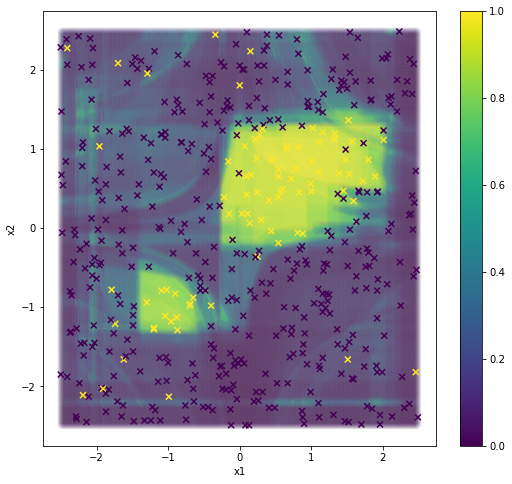

In [48]:
fig, ax = plt.subplots(1, 1, figsize=(1.1* PLOT_SIZE/2, PLOT_SIZE/2))

fx_plot = fx_gb(coordinates)[:,1]
plt.scatter(x1, x2, c=fx_plot, vmin=0, vmax=1, alpha = 0.01)
plt.scatter(X_test[:,0], X_test[:,1], c=y_test, marker='x')
plt.colorbar()

ax.set_xlabel('x1')
ax.set_ylabel('x2')

plt.show()

In [49]:
fx_test_gb = fx_gb(X_test)[:,1]
auc_gb = roc_auc_score(y_test, fx_test_gb)
print('AUC (Baseline): ' + str(round(auc_baseline, 2)))
print('AUC (Logistic): ' + str(round(auc_logistic, 2)))
print('AUC (SVM): ' + str(round(auc_svc, 2)))
print('AUC (Random Forests): ' + str(round(auc_rf, 2)))
print('AUC (Gradient Boosting): ' + str(round(auc_gb, 2)))

AUC (Baseline): 0.5
AUC (Logistic): 0.9
AUC (SVM): 0.91
AUC (Random Forests): 0.88
AUC (Gradient Boosting): 0.9


## Wrapping Up...

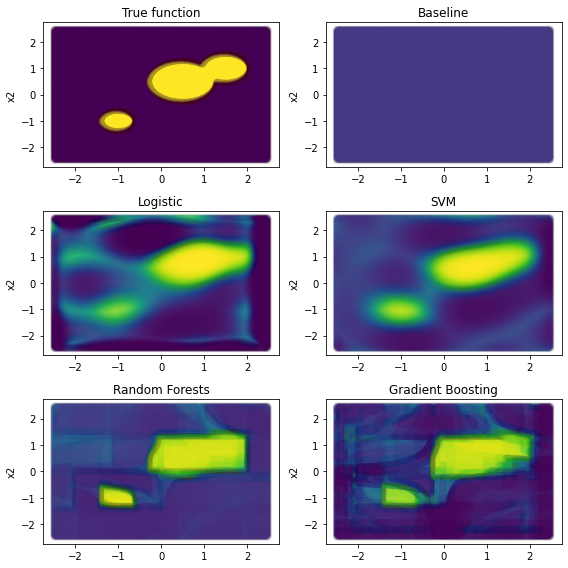

In [59]:
model_names = [
    'True function',
    'Baseline',
    'Logistic',
    'SVM',
    'Random Forests',
    'Gradient Boosting'
]

model_fxs = [
    [true_function(x1,x2) for x1,x2 in coordinates],
    [fx_baseline(x1,x2) for x1, x2 in coordinates],
    fx_lm(coordinates)[:,1],
    fx_svc(coordinates)[:,1],
    fx_rf(coordinates)[:,1],
    fx_gb(coordinates)[:,1]
]

K = len(model_names)

fig, ax = plt.subplots(3, 2, figsize=(PLOT_SIZE/2, PLOT_SIZE/2))

for k in np.arange(K):
    
    i = int(np.floor(k/2))
    j = int(k % 2)
    fx = model_fxs[k]
    model = model_names[k]
    
    ax[i,j].scatter(x1, x2, c=fx, vmin=0, vmax=1, alpha = 0.01)
    ax[i,j].set_ylabel('x2')
    ax[i,j].set_title(model)

fig.tight_layout()
plt.show()

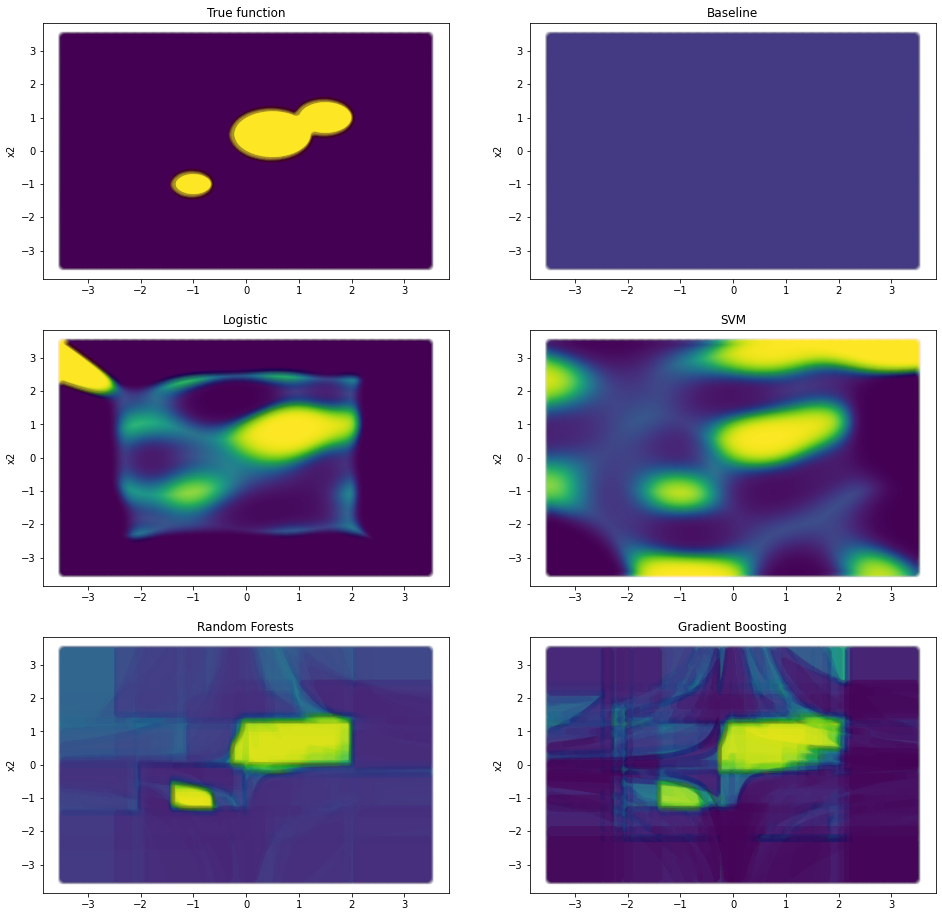

In [57]:
x1_extended = np.arange(x1_min - 2, x1_max + 2, 0.01)
x2_extended = np.arange(x2_min - 2, x2_max + 2, 0.01)
coordinates_extended = np.array([x for x in itertools.product(x1_extended,x2_extended)])
x1_extended = [x1 for x1,x2 in coordinates_extended]
x2_extended = [x2 for x1,x2 in coordinates_extended]

model_names = [
    'True function',
    'Baseline',
    'Logistic',
    'SVM',
    'Random Forests',
    'Gradient Boosting'
]

model_fxs = [
    [true_function(x1,x2) for x1,x2 in coordinates_extended],
    [fx_baseline(x1,x2) for x1, x2 in coordinates_extended],
    fx_lm(coordinates_extended)[:,1],
    fx_svc(coordinates_extended)[:,1],
    fx_rf(coordinates_extended)[:,1],
    fx_gb(coordinates_extended)[:,1]
]

K = len(model_names)

fig, ax = plt.subplots(3, 2, figsize=(PLOT_SIZE/2, PLOT_SIZE/2))

for k in np.arange(K):
    
    i = int(np.floor(k/2))
    j = int(k % 2)
    fx = model_fxs[k]
    model = model_names[k]
    
    ax[i,j].scatter(x1_extended, x2_extended, c=fx, vmin=0, vmax=1, alpha = 0.01)
    ax[i,j].set_ylabel('x2')
    ax[i,j].set_title(model)

fig.tight_layout()
plt.show()